<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/Adversarial_Patch_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch Attack

## Load Data from CIFAR

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load CIFAR10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

## Load Pretrained Model

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18  # Assuming you're using a standard architecture


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


In [5]:

# Step 1: Re-declare BasicBlock and ResNet
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
# Step 2: Instantiate the model
model = ResNet(BasicBlock, [2, 2, 2, 2])

# Use DataParallel
if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

# Step 3: Load the pretrained weights
# (make sure ResNet18.pt is in your working directory or give full path)
pretrained_path = "ResNet18.pt"
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Step 4: Move model to device and eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Pretrained ResNet18 loaded and ready!")

Pretrained ResNet18 loaded and ready!


## Adversarial Patch Training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, trainloader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")

# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            # Display only if the original prediction is correct and the patched prediction is incorrect
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                # Normalize back to [0, 1] range for visualization
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                # Plot images with a fixed size to match CIFAR-10
                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")
                axes[0].axis('off')

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")
                axes[1].axis('off')

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return


Training for patch size: (3, 3)
Epoch 1/20, Loss: 10.5078
Epoch 2/20, Loss: 7.6968
Epoch 3/20, Loss: 5.7941
Epoch 4/20, Loss: 5.6435
Epoch 5/20, Loss: 5.5655
Epoch 6/20, Loss: 5.5572
Epoch 7/20, Loss: 5.5040
Epoch 8/20, Loss: 5.4579
Epoch 9/20, Loss: 5.4278
Epoch 10/20, Loss: 5.3940
Epoch 11/20, Loss: 5.3586
Epoch 12/20, Loss: 5.3452
Epoch 13/20, Loss: 5.3014
Epoch 14/20, Loss: 5.3195
Epoch 15/20, Loss: 5.3169
Epoch 16/20, Loss: 5.3493
Epoch 17/20, Loss: 5.3276
Epoch 18/20, Loss: 5.2887
Epoch 19/20, Loss: 5.3126
Epoch 20/20, Loss: 5.3068
Visualizing patch of size (3, 3)


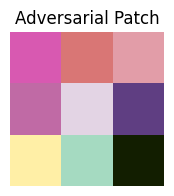

Attack Success Rate: 88.94%


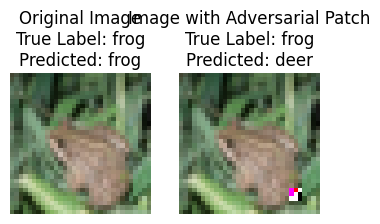

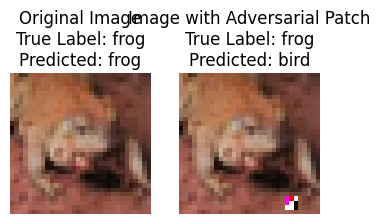

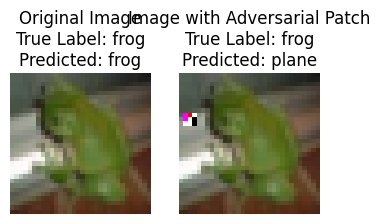

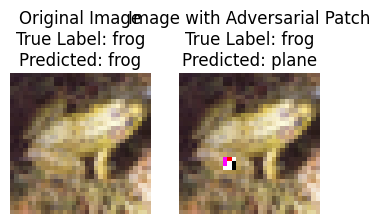

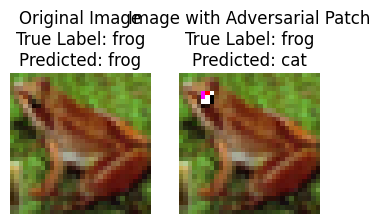


Training for patch size: (5, 5)
Epoch 1/20, Loss: 9.9499
Epoch 2/20, Loss: 6.7107
Epoch 3/20, Loss: 5.6646
Epoch 4/20, Loss: 5.5151
Epoch 5/20, Loss: 5.4255
Epoch 6/20, Loss: 5.3783
Epoch 7/20, Loss: 5.3300
Epoch 8/20, Loss: 5.2761
Epoch 9/20, Loss: 5.2408
Epoch 10/20, Loss: 5.1902
Epoch 11/20, Loss: 5.1654
Epoch 12/20, Loss: 5.1509
Epoch 13/20, Loss: 5.0900
Epoch 14/20, Loss: 5.0852
Epoch 15/20, Loss: 5.0448
Epoch 16/20, Loss: 4.9995
Epoch 17/20, Loss: 4.9887
Epoch 18/20, Loss: 4.9705
Epoch 19/20, Loss: 4.9451
Epoch 20/20, Loss: 4.9486
Visualizing patch of size (5, 5)


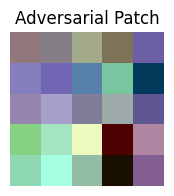

Attack Success Rate: 89.43%


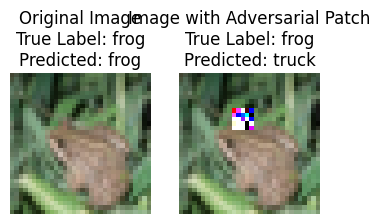

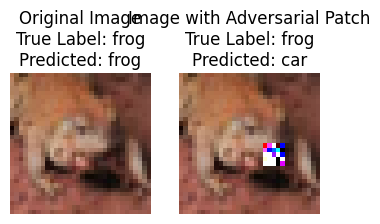

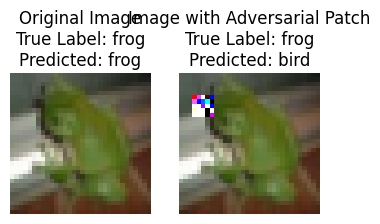

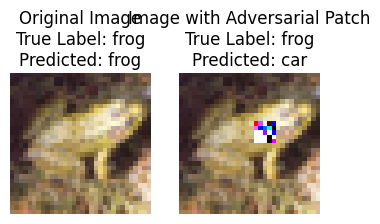

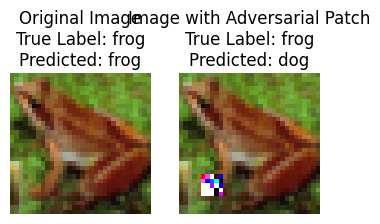


Training for patch size: (7, 7)
Epoch 1/20, Loss: 9.2110
Epoch 2/20, Loss: 6.7189
Epoch 3/20, Loss: 5.6248
Epoch 4/20, Loss: 5.3571
Epoch 5/20, Loss: 5.1674
Epoch 6/20, Loss: 5.0939
Epoch 7/20, Loss: 4.9959
Epoch 8/20, Loss: 4.9440
Epoch 9/20, Loss: 4.9036
Epoch 10/20, Loss: 4.8616
Epoch 11/20, Loss: 4.8078
Epoch 12/20, Loss: 4.7845
Epoch 13/20, Loss: 4.7879
Epoch 14/20, Loss: 4.7600
Epoch 15/20, Loss: 4.7557
Epoch 16/20, Loss: 4.7423
Epoch 17/20, Loss: 4.7350
Epoch 18/20, Loss: 4.7105
Epoch 19/20, Loss: 4.7218
Epoch 20/20, Loss: 4.6961
Visualizing patch of size (7, 7)


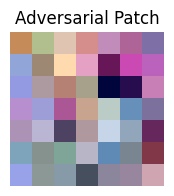

Attack Success Rate: 88.84%


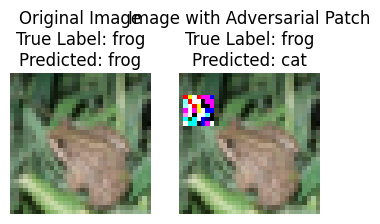

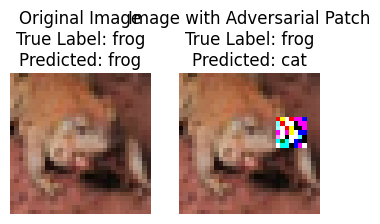

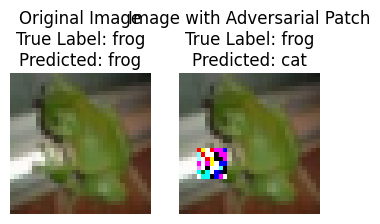

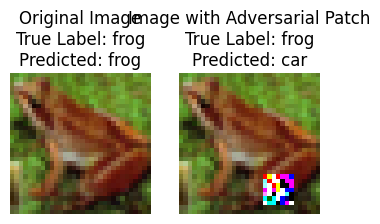

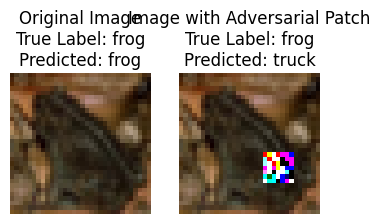


Training for patch size: (16, 16)
Epoch 1/20, Loss: 6.3853
Epoch 2/20, Loss: 5.1294
Epoch 3/20, Loss: 4.6809
Epoch 4/20, Loss: 4.3921
Epoch 5/20, Loss: 4.1749
Epoch 6/20, Loss: 3.9960
Epoch 7/20, Loss: 3.8750
Epoch 8/20, Loss: 3.7834
Epoch 9/20, Loss: 3.6933
Epoch 10/20, Loss: 3.6292
Epoch 11/20, Loss: 3.5781
Epoch 12/20, Loss: 3.5320
Epoch 13/20, Loss: 3.4774
Epoch 14/20, Loss: 3.4658
Epoch 15/20, Loss: 3.4159
Epoch 16/20, Loss: 3.4136
Epoch 17/20, Loss: 3.3907
Epoch 18/20, Loss: 3.3676
Epoch 19/20, Loss: 3.3468
Epoch 20/20, Loss: 3.3371
Visualizing patch of size (16, 16)


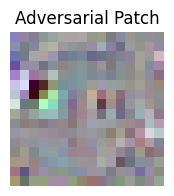

Attack Success Rate: 88.16%


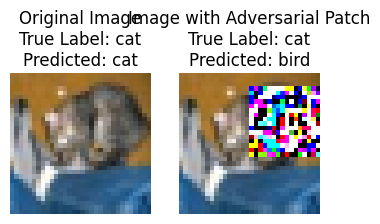

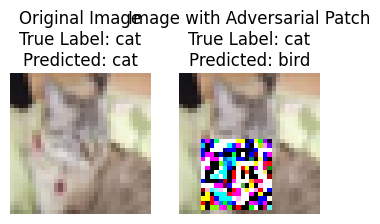

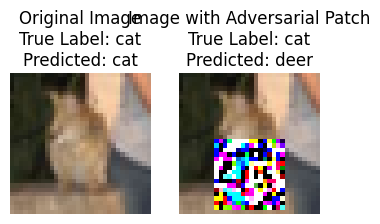

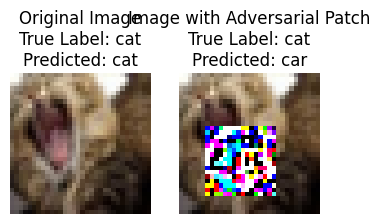

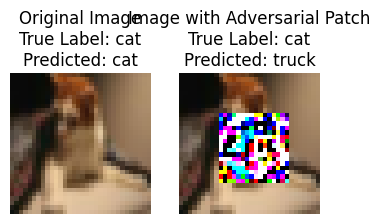

In [12]:

# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches of different sizes
for patch_size in patch_sizes:
    print(f"\nTraining for patch size: {patch_size}")
    patch = create_patch(patch_size)
    train_adversarial_patch(model, patch, target_class=None, num_epochs=20)

    # Save the patch
    torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}.pth')

    # Visualize the patch
    print(f"Visualizing patch of size {patch_size}")
    visualize_patch(patch)

    # Evaluate attack success rate
    evaluate_patch(model, patch, testloader)

    # Visualize misclassified examples with the adversarial patch
    visualize_misclassified_patched_images(model, patch, testloader, classes, num_examples=5)

## Train for Adversarial Patch

In [13]:
# # Create an adversarial patch
# patch_size = (3, 3, 3)  # Example size, adjust as necessary
# patch = tf.Variable(np.random.rand(*patch_size) * 2 - 1, dtype=tf.float32)  # Initialize patch

In [14]:
# # Function to apply the patch to an image
# def apply_patch(image, patch, location=(20, 20)):
#     patched_image = image.numpy().copy()
#     x, y = location
#     patched_image[x:x+patch_size[0], y:y+patch_size[1], :] = patch.numpy()
#     return patched_image

In [15]:
# # Adversarial training of the patch
# optimizer = tf.optimizers.Adam(learning_rate=0.01)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
# def train_step(image, label):
#     with tf.GradientTape() as tape:
#         # Apply the patch
#         patched_image = apply_patch(image, patch)
#         patched_image = tf.convert_to_tensor(patched_image[None, ...])
#         # Predict on the patched image
#         prediction = model(patched_image)
#         loss = -loss_fn(label[None, ...], prediction)  # Negative loss for maximization
#     gradients = tape.gradient(loss, patch)
#     optimizer.apply_gradients([(gradients, patch)])
#     return loss

In [17]:
# # Train the patch for a number of epochs
# epochs = 10
# batch_size = 32
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     for i in range(0, len(x_test), batch_size):
#         batch_images = tf.convert_to_tensor(x_test[i:i+batch_size])
#         batch_labels = tf.convert_to_tensor(y_test[i:i+batch_size])
#         loss = train_step(batch_images, batch_labels)
#     print(f"Loss: {loss.numpy()}")

In [18]:
# # Evaluate the success rate
# misclassified = 0
# for i in range(len(x_test)):
#     patched_image = apply_patch(x_test[i], patch)
#     prediction = np.argmax(model.predict(patched_image[None, ...]))
#     true_label = y_test[i, 0]
#     if prediction != true_label:
#         misclassified += 1

In [19]:
# success_rate = misclassified / len(x_test) * 100
# print(f"Success rate of adversarial attack: {success_rate}%")

# # Visualize the patch
# plt.imshow(patch.numpy())
# plt.title("Adversarial Patch")
# plt.show()

# # Visualize some misclassified images
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# misclassified_indices = [idx for idx in range(len(x_test)) if np.argmax(model.predict(x_test[idx][None, ...])) != y_test[idx][0]]
# selected_indices = np.random.choice(misclassified_indices, size=3, replace=False)
# for i, idx in enumerate(selected_indices):
#     axes[i].imshow(apply_patch(x_test[idx], patch))
#     axes[i].set_title(f"True: {y_test[idx][0]}, Pred: {np.argmax(model.predict(apply_patch(x_test[idx], patch)[None, ...]))}")
# plt.show()